In [1]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ta.300.vec.gz
!gunzip cc.ta.300.vec.gz
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

--2025-04-15 05:03:49--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ta.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.50, 13.35.7.82, 13.35.7.128, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1213735937 (1.1G) [binary/octet-stream]
Saving to: ‘cc.ta.300.vec.gz’

cc.ta.300.vec.gz    100%[===================>]   1.13G  37.5MB/s    in 33s     

2025-04-15 05:04:23 (35.0 MB/s) - ‘cc.ta.300.vec.gz’ saved [1213735937/1213735937]



In [2]:
import pandas as pd
import numpy as np
import re
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score


2025-04-15 05:05:04.249243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744693504.449765      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744693504.505125      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"<handle replaced>", "[USER]", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(rf"[{string.punctuation}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text
def get_majority_label(row):
    valid_votes = [float(v) for v in row if str(v).replace('.', '', 1).isdigit() and float(v) in [0.0, 1.0]]
    return 1 if valid_votes.count(1.0) >= valid_votes.count(0.0) else 0 if valid_votes else None

In [4]:
hs_train = pd.read_csv("/kaggle/input/hate-speech/tamil_train.csv")
hs_val = pd.read_csv("/kaggle/input/hate-speech/tamil_val.csv")
hs_train["text"] = hs_train["text"].apply(normalize_text)
hs_val["text"] = hs_val["text"].apply(normalize_text)

# Tokenizer
max_features, max_len, embed_size = 10000, 100, 300
keras_tokenizer = Tokenizer(num_words=max_features)
keras_tokenizer.fit_on_texts(hs_train["text"])

# Encode hate speech texts
X_train = pad_sequences(keras_tokenizer.texts_to_sequences(hs_train["text"]), maxlen=max_len)
X_val = pad_sequences(keras_tokenizer.texts_to_sequences(hs_val["text"]), maxlen=max_len)
y_train, y_val = hs_train["label"].tolist(), hs_val["label"].tolist()

# FastText embeddings
embedding_matrix = np.zeros((len(keras_tokenizer.word_index) + 1, embed_size))
with open("cc.ta.300.vec", encoding="utf8") as f:
    next(f)
    for line in f:
        values = line.rstrip().split()
        word = values[0]
        if word in keras_tokenizer.word_index:
            embedding_matrix[keras_tokenizer.word_index[word]] = np.asarray(values[1:], dtype="float32")

In [5]:
class FusionDataset(Dataset):
    def __init__(self, texts, glove_inputs, labels, tokenizer, max_len=128):
        self.texts = texts
        self.glove_inputs = glove_inputs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        bert_encoded = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': bert_encoded['input_ids'].squeeze(),
            'attention_mask': bert_encoded['attention_mask'].squeeze(),
            'glove_input': torch.tensor(self.glove_inputs[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [6]:
class BiLSTMEncoder(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        vocab_size, embed_size = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)
        self.conv = nn.Conv1d(embed_size, 64, kernel_size=2)
        self.lstm = nn.LSTM(64, 128, batch_first=True, bidirectional=True)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embedding(x)         # (B, T, E)
        x = x.permute(0, 2, 1)        # (B, E, T)
        x = self.conv(x)              # (B, C, T-1)
        x = x.permute(0, 2, 1)        # (B, T-1, C)
        x, _ = self.lstm(x)           # (B, T-1, H*2)
        x = x.permute(0, 2, 1)        # (B, H*2, T-1)
        x = self.pool(x).squeeze(2)   # (B, H*2)
        x = torch.relu(self.linear(x))
        return self.dropout(x)        # (B, 128)

class IndicBERTEncoder(nn.Module):
    def __init__(self, model_name="ai4bharat/indic-bert"):
        super(IndicBERTEncoder, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.linear = nn.Linear(self.bert.config.hidden_size, 128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]  # (B, hidden)
        x = torch.relu(self.linear(cls))
        return self.dropout(x)  # (B, 128)


In [7]:

# class FusionClassifier(nn.Module):
#     def __init__(self, embedding_matrix):
#         super(FusionClassifier, self).__init__()

#         self.bert_encoder = IndicBERTEncoder()             # Outputs x1 (B, 128)
#         self.bilstm_encoder = BiLSTMEncoder(embedding_matrix)  # Outputs x2 (B, 128)

#         # Use attention over 4 vectors: x1, x2, x1 - x2, x1 * x2
#         self.attn = nn.MultiheadAttention(embed_dim=128, num_heads=4, batch_first=True)

#         # MLP head after attention
#         self.fusion_head = nn.Sequential(
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 2)  # Output logits
#         )

#     def forward(self, input_ids, attention_mask, fasttex_input):
#         x1 = self.bert_encoder(input_ids, attention_mask)     # (B, 128)
#         x2 = self.bilstm_encoder(fasttex_input)                 # (B, 128)

#         # Stack fused representations into a pseudo-sequence (B, 4, 128)
#         fusion_seq = torch.stack([x1, x2, x1 - x2, x1 * x2], dim=1)

#         # Apply attention across the 4 vectors
#         attn_out, _ = self.attn(fusion_seq, fusion_seq, fusion_seq)  # (B, 4, 128)

#         # Pool (mean) across the 4 outputs
#         pooled = attn_out.mean(dim=1)  # (B, 128)

#         return self.fusion_head(pooled)

In [8]:
class FusionClassifier(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.bert_encoder = IndicBERTEncoder()
        self.bilstm_encoder = BiLSTMEncoder(embedding_matrix)
        self.fusion_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, input_ids, attention_mask, glove_input):
        x1 = self.bert_encoder(input_ids, attention_mask)
        x2 = self.bilstm_encoder(glove_input)
        x = torch.cat([x1, x2, x1 - x2, x1 * x2], dim=1)
        return self.fusion_head(x)

In [15]:
from transformers import AutoTokenizer
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")

train_ds = FusionDataset(hs_train["text"].tolist(), X_train, y_train, tokenizer)
val_ds = FusionDataset(hs_val["text"].tolist(), X_val, y_val, tokenizer)
train_loader, val_loader = DataLoader(train_ds, 16, shuffle=True), DataLoader(val_ds, 16)

label_counts = Counter(y_train)
total = sum(label_counts.values())
class_weights = [total / label_counts[i] for i in range(len(label_counts))]
class_weights = [w / sum(class_weights) for w in class_weights]
class_weights_tensor = torch.tensor(class_weights).to(device)

model = FusionClassifier(embedding_matrix).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss(weight = class_weights_tensor)
best_f1 = 0.0

for epoch in range(5):
    model.train(); total_loss = 0
    for batch in tqdm(train_loader, desc=f"Pretraining Epoch {epoch+1}"):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        outputs = model(**inputs)
        loss = criterion(outputs, batch['label'].to(device))
        loss.backward(); optimizer.step()
        total_loss += loss.item()

    preds, targets = [], []
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            outputs = model(**inputs)
            preds += torch.argmax(outputs, dim=1).cpu().tolist()
            targets += batch["label"].tolist()

    f1 = f1_score(targets, preds, average="weighted")
    print(f"Epoch {epoch+1} F1: {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "fusion_tamil_pretrained_hatespeech.pt")
        tokenizer.save_pretrained("fusion_tokenizer_ta")

Pretraining Epoch 1: 100%|██████████| 1125/1125 [03:31<00:00,  5.32it/s]


Epoch 1 F1: 0.8151


Pretraining Epoch 2: 100%|██████████| 1125/1125 [03:31<00:00,  5.31it/s]


Epoch 2 F1: 0.8218


Pretraining Epoch 3: 100%|██████████| 1125/1125 [03:31<00:00,  5.31it/s]


Epoch 3 F1: 0.7857


Pretraining Epoch 4: 100%|██████████| 1125/1125 [03:31<00:00,  5.31it/s]


Epoch 4 F1: 0.8266


Pretraining Epoch 5: 100%|██████████| 1125/1125 [03:31<00:00,  5.31it/s]


Epoch 5 F1: 0.8282


In [17]:
from sklearn.model_selection import train_test_split
df = pd.read_csv("/kaggle/input/gender-abuse-dataset/train_ta_l1.csv")
annotation_cols = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']

def get_majority_label(row):
    valid_votes = [float(v) for v in row if str(v).replace('.', '', 1).isdigit() and float(v) in [0.0, 1.0]]
    return 1 if valid_votes.count(1.0) >= valid_votes.count(0.0) else 0 if valid_votes else None
    
df['label'] = df[annotation_cols].apply(get_majority_label, axis=1)
df = df[['text', 'label']].dropna()
df['label'] = df['label'].astype(int)
df['text'] = df['text'].apply(normalize_text)

X_seq = keras_tokenizer.texts_to_sequences(df['text'])
X_pad = pad_sequences(X_seq, maxlen=max_len)
y = df['label'].tolist()

train_texts, val_texts, X_train_abuse, X_val_abuse, y_train_abuse, y_val_abuse = train_test_split(
    df["text"].tolist(), X_pad, y, test_size=0.2, random_state=42)

train_ds = FusionDataset(train_texts, X_train_abuse, y_train_abuse, tokenizer)
val_ds = FusionDataset(val_texts, X_val_abuse, y_val_abuse, tokenizer)
train_loader, val_loader = DataLoader(train_ds, 16, shuffle=True), DataLoader(val_ds, 16)



In [18]:
from collections import Counter
model = FusionClassifier(embedding_matrix).to(device)
model.load_state_dict(torch.load("fusion_tamil_pretrained_hatespeech.pt"))

label_counts = Counter(y_train_abuse)
total = sum(label_counts.values())
class_weights = [total / label_counts[i] for i in range(len(label_counts))]
class_weights = [w / sum(class_weights) for w in class_weights]
class_weights_tensor = torch.tensor(class_weights).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight = class_weights_tensor)
best_f1 = 0.0
train_losses, val_losses = [], []

for epoch in range(7):
    model.train(); total_loss = 0
    for batch in tqdm(train_loader, desc=f"Finetune Epoch {epoch+1}"):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        loss = criterion(model(**inputs), batch["label"].to(device))
        loss.backward(); optimizer.step(); total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    model.eval(); preds, targets = [], []; val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            out = model(**inputs)
            val_loss += criterion(out, batch["label"].to(device)).item()
            preds += torch.argmax(out, dim=1).cpu().tolist()
            targets += batch["label"].tolist()
    val_losses.append(val_loss / len(val_loader))

    f1 = f1_score(targets, preds, average="weighted")
    print(f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | F1: {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "fusion_model_tamil_abuse.pt")
        
model.load_state_dict(torch.load("fusion_model_tamil_abuse.pt"))
model.eval()

/tmp/ipykernel_31/2633662623.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_tamil_pretrained_hatespeech.pt"))
Finetune Epoch 1:

Train Loss: 0.6604 | Val Loss: 0.5683 | F1: 0.7220


Finetune Epoch 2: 100%|██████████| 339/339 [01:04<00:00,  5.28it/s]


Train Loss: 0.5723 | Val Loss: 0.5501 | F1: 0.7267


Finetune Epoch 3: 100%|██████████| 339/339 [01:04<00:00,  5.29it/s]


Train Loss: 0.5628 | Val Loss: 0.5403 | F1: 0.7367


Finetune Epoch 4: 100%|██████████| 339/339 [01:04<00:00,  5.29it/s]


Train Loss: 0.5448 | Val Loss: 0.5384 | F1: 0.7380


Finetune Epoch 5: 100%|██████████| 339/339 [01:04<00:00,  5.28it/s]


Train Loss: 0.5399 | Val Loss: 0.5294 | F1: 0.7411


Finetune Epoch 6: 100%|██████████| 339/339 [01:04<00:00,  5.28it/s]


Train Loss: 0.5302 | Val Loss: 0.5217 | F1: 0.7477


Finetune Epoch 7: 100%|██████████| 339/339 [01:04<00:00,  5.29it/s]
/tmp/ipykernel_31/2633662623.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t

Train Loss: 0.5217 | Val Loss: 0.5198 | F1: 0.7423



Final Classification Report:

              precision    recall  f1-score   support

    Not Hate       0.81      0.72      0.77       778
        Hate       0.68      0.78      0.72       578

    accuracy                           0.75      1356
   macro avg       0.74      0.75      0.74      1356
weighted avg       0.76      0.75      0.75      1356



NameError: name 'val_targets' is not defined


Final Classification Report:

              precision    recall  f1-score   support

    Not Hate       0.81      0.72      0.77       778
        Hate       0.68      0.78      0.72       578

    accuracy                           0.75      1356
   macro avg       0.74      0.75      0.74      1356
weighted avg       0.76      0.75      0.75      1356



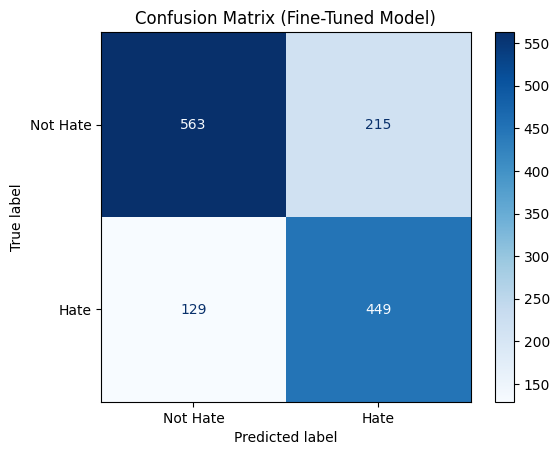

In [19]:
final_preds, final_targets = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Eval", leave=False):
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        final_preds += torch.argmax(outputs, dim=1).cpu().tolist()
        final_targets += labels.cpu().tolist()
print("\nFinal Classification Report:\n")
print(classification_report(final_targets, final_preds, target_names=["Not Hate", "Hate"]))

cm = confusion_matrix(final_targets, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hate", "Hate"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Fine-Tuned Model)")
plt.show()

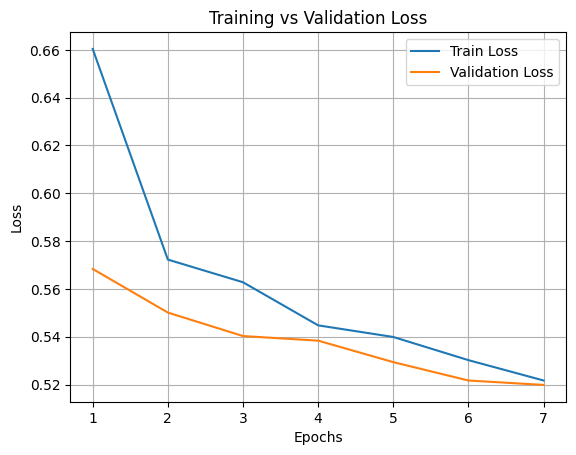

In [20]:
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_31/2652460191.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_model_tamil_abuse.pt"))  # ← CHANGE this if filena

Saved predictions to: Task1_output_Tamil.csv

F1-score: 0.5264 | Precision: 0.7175 | Recall: 0.6026

Classification Report:

              precision    recall  f1-score   support

    Not Hate       0.57      0.98      0.72       596
        Hate       0.88      0.19      0.31       539

    accuracy                           0.60      1135
   macro avg       0.73      0.58      0.52      1135
weighted avg       0.72      0.60      0.53      1135



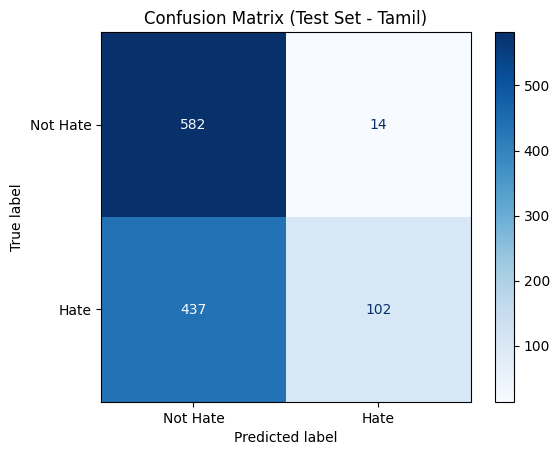

In [21]:
test_df = pd.read_csv("/kaggle/input/gender-abuse-dataset/test_ta_l1.csv")
annotation_cols = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
test_df['label'] = test_df[annotation_cols].apply(get_majority_label, axis=1)
test_df = test_df[['text', 'label']].dropna()
test_df['label'] = test_df['label'].astype(int)
test_df['text'] = test_df['text'].apply(normalize_text)

# Tokenize using previously fitted keras_tokenizer
test_seq = keras_tokenizer.texts_to_sequences(test_df['text'])
test_fasttex = pad_sequences(test_seq, maxlen=max_len, padding='post')
test_labels = test_df['label'].tolist()

# Dataset and loader
test_dataset = FusionDataset(test_df['text'].tolist(), test_fasttex, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load pretrained + fine-tuned model (use correct path if different)
model = FusionClassifier(embedding_matrix).to(device)
model.load_state_dict(torch.load("fusion_model_tamil_abuse.pt"))  # ← CHANGE this if filename differs
model.eval()

# Run inference
all_preds, all_targets = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        preds = torch.argmax(outputs, dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_targets.extend(labels.cpu().tolist())

# Save predictions
output_df = pd.DataFrame({'id': np.arange(1, len(all_preds)+1), 'value': all_preds})
output_df.to_csv('/kaggle/working/Task1_output_Tamil.csv', index=False)
print("Saved predictions to: Task1_output_Tamil.csv")

# Metrics
f1 = f1_score(all_targets, all_preds, average="weighted")
precision = precision_score(all_targets, all_preds, average="weighted")
recall = recall_score(all_targets, all_preds, average="weighted")

print(f"\nF1-score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
print("\nClassification Report:\n")
print(classification_report(all_targets, all_preds, target_names=["Not Hate", "Hate"]))

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hate", "Hate"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Test Set - Tamil)")
plt.show()
